<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch1_SparseMatrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse matrix demo
APPM 4600

Copyright Dept of Applied Math, University of Colorado Boulder. Released under a BSD 3-clause license

Learning objectives:
1. Just because a matrix has a lot of zero entries doesn't mean that your code will automatically take advantage of it. You need to explicitly use a sparse format.
2. Using a sparse format, if the matrix isn't extremely sparse, it may not be worth it (in terms of speed and/or memory)
3. Depending on the kind of sparse format, some operations may be fast or slow

In [4]:
import scipy
import numpy as np

# How to take advantage of sparsity
Even if a matrix is (mathematically) sparse, if we don't use a sparse data structure, the code won't take much advantage of it

In [6]:
n = int(3e3)
A = np.random.randn(n, n) # a dense matrix
# B = np.zeros( (n,n) )
B = np.eye(n) # identity matrix, very sparse
B[:,0] = -8.  # add some nonzero entries here and there
B[4,:] = 0.004
B[14,20] = 9.8
B[1099,2103] = -4  
B[-1,-1] = 10234. # B is still a very sparse matrix!

x = np.ones( (n,1) )

# Perform matrix-vector multiplication and measure the execution time
%timeit A@x
%timeit B@x

1.96 ms ± 250 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.97 ms ± 233 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


There was no speed advantage with the sparse matrix... because we did not use a sparse data structure.

Let's explicitly tell the computer to store it in a sparse data structure:

In [8]:
B_sparse = scipy.sparse.csr_array(B) # generally prefer .csr_array over the (deprecated) .csr_matrix
%timeit B_sparse@x

126 μs ± 270 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


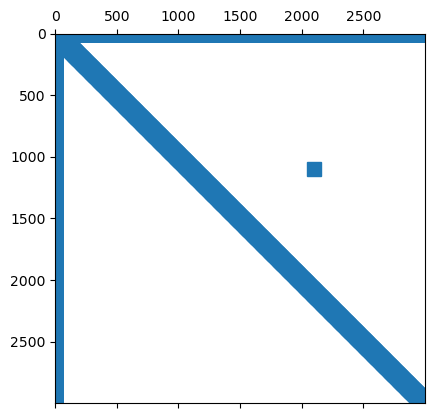

In [9]:
# Btw, a useful tool to visualize the nonzero entries of a sparse matrix:
from matplotlib import pyplot as plt
plt.spy(B_sparse)
plt.show()

Now it's must faster!

# Sometimes we don't want to take advantage of sparsity!
In this example, for the 50\% sparse matrix, using the sparse data structure is **slower** than ignoring the sparsity

In [10]:
n = int(3e3)
A = np.random.randn(n, n) # a dense matrix
B = scipy.sparse.random_array( (n,n), density=0.01, format='csr') # very sparse
C = scipy.sparse.random_array( (n,n), density=0.1, format='csr') # a little sparse
D = scipy.sparse.random_array( (n,n), density=0.5, format='csr') # slightly sparse
E = scipy.sparse.random_array( (n,n), density=0.9, format='csr') # not really sparse

%timeit A@x
%timeit B@x
%timeit C@x
%timeit D@x
%timeit E@x

1.37 ms ± 214 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
171 μs ± 1.15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
776 μs ± 3.44 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.18 ms ± 26.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.53 ms ± 11.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


There may also not be a memory savings

In [11]:
def memory_usage(A):
    """ returns the memory footprint of the matrix A, in MB """
    if scipy.sparse.issparse(A):
        m = A.data.nbytes + A.indices.nbytes + A.indptr.nbytes
    else:
        m = A.nbytes
    return m/1024/1024
for matrix in [A,B,C,D,E]:
    print(f"{memory_usage(matrix)=:5.1f} MB" )

memory_usage(matrix)= 68.7 MB
memory_usage(matrix)=  1.0 MB
memory_usage(matrix)= 10.3 MB
memory_usage(matrix)= 51.5 MB
memory_usage(matrix)= 92.7 MB


# Exploiting the exact data structure

Common sparse data structures:
- `coo` for COOrdinate format
- `csc` for Compressed Sparse Column format
- `csr` for Compressed Sparse Row
- `bsr` for Block Sparse Row

There are also other things like `dia` (Sparse array with DIAgonal storage), `dok` (Dictionary Of Keys), `lil` (Row-based LIst of Lists)

The type you use affects the efficiency of operations. Below, we work with a `csr` type:

In [12]:
n = int(5e3)

B = scipy.sparse.random_array( (n,n), density=0.1, format='csr') # sparse

def row_norms(A):
    nrms = np.zeros( A.shape[0] )
    for i in range( A.shape[0] ):
        nrms[i] = np.linalg.norm( A[i,:].toarray() )
        # nrms[i] = scipy.sparse.linalg.norm( A[i,:] )
    return nrms

def col_norms(A):
    nrms = np.zeros( A.shape[1] )
    for j in range( A.shape[1] ):
        nrms[j] = np.linalg.norm( A[:,j].toarray() )
        # nrms[j] = scipy.sparse.linalg.norm( A[:,j] )
    return nrms

Because of the `csr` structure, it's very quick to get an entire row, but not so quick to get an entire column (for two reasons: one, the lookup process isn't trivial, and two, the data isn't stored contiguously)

In [17]:
%time nrms_row = row_norms(B)
%time nrms_col = col_norms(B)

CPU times: user 774 ms, sys: 5.23 ms, total: 779 ms
Wall time: 782 ms
CPU times: user 8.28 s, sys: 40 ms, total: 8.32 s
Wall time: 8.33 s


and if we switch from `csr` format to `csc` format, then the roles of rows and columns are switched, so now finding columns is fast

In [19]:
C = scipy.sparse.csc_array(B) # this might take a few moments !?

In [20]:
%time nrms_row = row_norms(C)
%time nrms_col = col_norms(C)

CPU times: user 8.21 s, sys: 45.7 ms, total: 8.26 s
Wall time: 8.26 s
CPU times: user 766 ms, sys: 3.6 ms, total: 770 ms
Wall time: 770 ms
